In [64]:
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import opendatasets as od
import pandas
from keras import layers, Model

In [65]:
od.download("https://www.kaggle.com/datasets/gonzajl/neumona-x-rays-dataset")

Skipping, found downloaded files in "./neumona-x-rays-dataset" (use force=True to force download)


In [66]:
datos = pandas.read_csv("./neumona-x-rays-dataset/dataset/datos.csv")

In [67]:
def cargar_imagenes(nombres, et):
    imagenes = []
    etiquetas = []
    for i in range(len(nombres)):
        ruta = "./neumona-x-rays-dataset/" + nombres[i]
        imagen = cv2.imread(ruta, cv2.IMREAD_COLOR)
        imagenes.append(imagen)
        etiquetas.append(list(et.iloc[i]))
    return imagenes, etiquetas

In [68]:
paths = datos.iloc[:, 0]
tags = datos.iloc[:, 1:]

In [69]:
imagenes, etiquetas = cargar_imagenes(paths, tags)

In [70]:
div_test = int(len(imagenes) * 0.8)
imagenes_entrenamiento, imagenes_prueba = imagenes[:div_test], imagenes[div_test:]
etiquetas_entrenamiento, etiquetas_prueba = etiquetas[:div_test], etiquetas[div_test:]

In [71]:
def mostrar_grafico_clases(etiquetas):
    cant_nuemonia = etiquetas.count([1, 0])
    cant_no_neumonia = etiquetas.count([0, 1])

    categorias = ["neumonia", "no-neumonia"]
    cantidades = [cant_nuemonia, cant_no_neumonia]

    plt.figure(figsize=(6, 4))
    barras = plt.bar(categorias, cantidades)

    for bar, cantidad in zip(barras, cantidades):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() / 2, str(cantidad), fontsize=12)

    plt.xlabel("Clases")
    plt.ylabel("Cantidad de Imágenes")
    plt.title("Cantidad de Imágenes por Clase")

    plt.show()

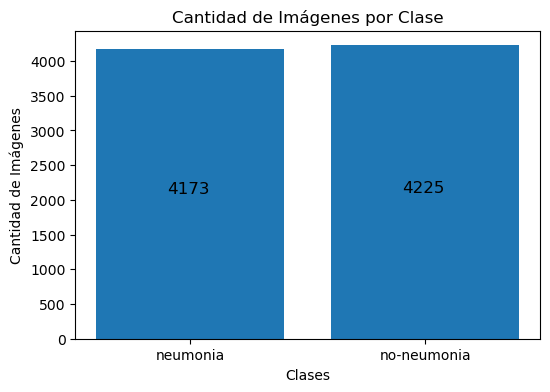

In [72]:
mostrar_grafico_clases(etiquetas_entrenamiento)

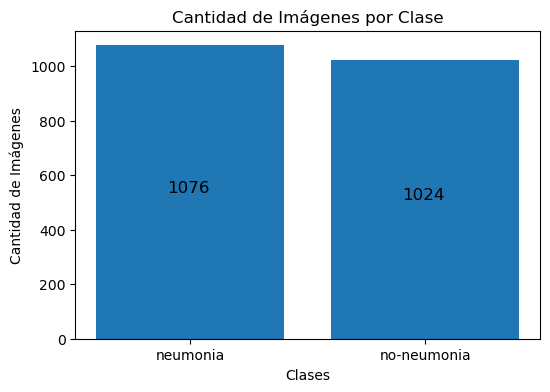

In [73]:
mostrar_grafico_clases(etiquetas_prueba)

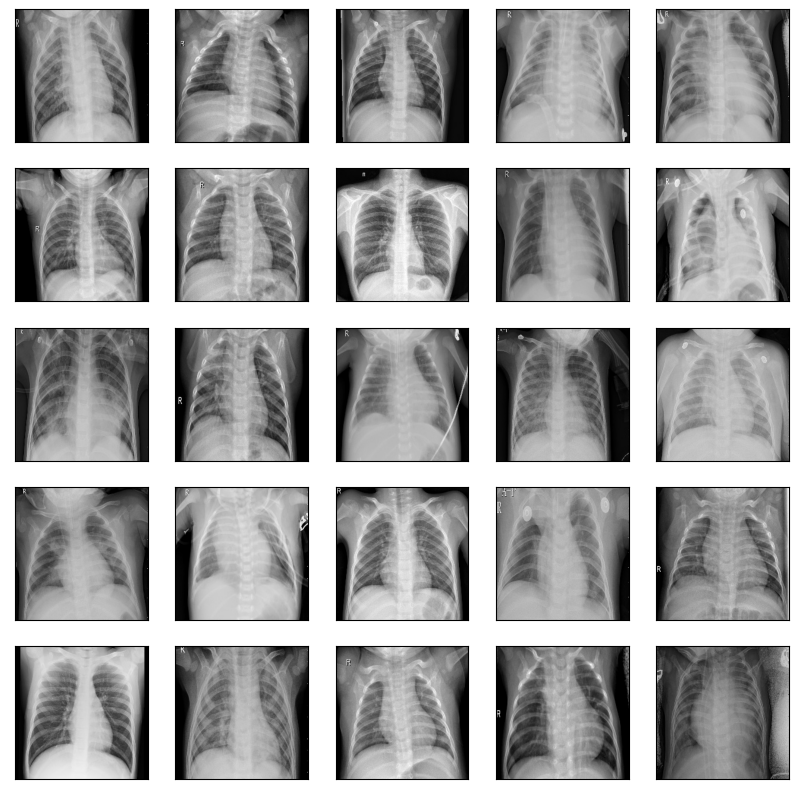

In [74]:
plt.figure(figsize = (10, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagenes_entrenamiento[i])

plt.show()

In [75]:
# Normalización de entradas y conversión de listas a tensores
imagenes_entrenamiento = np.array(imagenes_entrenamiento).astype(float) / 255
imagenes_prueba = np.array(imagenes_prueba).astype(float) / 255

etiquetas_entrenamiento = np.array(etiquetas_entrenamiento)
etiquetas_prueba = np.array(etiquetas_prueba)

In [76]:
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

base_model.trainable = False

num_classes = 2
x = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(num_classes, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=output)

In [77]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['categorical_accuracy'])

In [78]:
historial = model.fit(imagenes_entrenamiento, etiquetas_entrenamiento, epochs=20, validation_data=(imagenes_prueba, etiquetas_prueba))

Epoch 1/20


2023-10-19 16:34:49.532354: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5056536576 exceeds 10% of free system memory.


263/263 [==============================] - 210s 790ms/step - loss: 0.2093 - categorical_accuracy: 0.9132 - val_loss: 0.1519 - val_categorical_accuracy: 0.9448
Epoch 2/20
263/263 [==============================] - 206s 783ms/step - loss: 0.1288 - categorical_accuracy: 0.9552 - val_loss: 0.1046 - val_categorical_accuracy: 0.9633
Epoch 3/20
263/263 [==============================] - 205s 780ms/step - loss: 0.1071 - categorical_accuracy: 0.9624 - val_loss: 0.0961 - val_categorical_accuracy: 0.9652
Epoch 4/20
263/263 [==============================] - 205s 779ms/step - loss: 0.0973 - categorical_accuracy: 0.9653 - val_loss: 0.0867 - val_categorical_accuracy: 0.9695
Epoch 5/20
263/263 [==============================] - 207s 786ms/step - loss: 0.0857 - categorical_accuracy: 0.9715 - val_loss: 0.0793 - val_categorical_accuracy: 0.9724
Epoch 6/20
263/263 [==============================] - 205s 780ms/step - loss: 0.0785 - categorical_accuracy: 0.9730 - val_loss: 0.0765 - val_categorical_accuracy

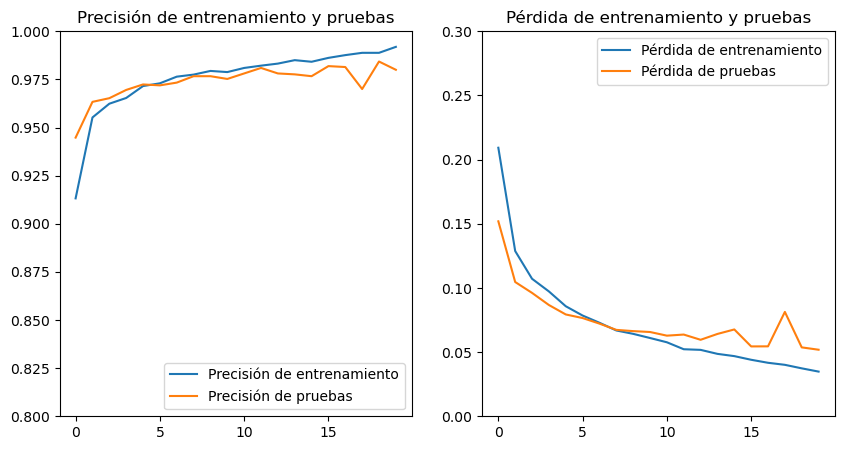

In [84]:
# Graficas de precisión y pérdida del modelo
acc = historial.history['categorical_accuracy']
val_acc = historial.history['val_categorical_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(20)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión de entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión de pruebas')
plt.legend(loc='lower right')
plt.ylim(0.8, 1)
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label= 'Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.ylim(0, 0.3)
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

In [85]:
def es_correcta(prediccion, esperado):
    return prediccion.index(max(prediccion)) == esperado.index(max(esperado))

In [86]:
correctas_segun_tipo = [0, 0]
falladas_segun_tipo = [0, 0]

predicciones = model.predict(imagenes_prueba)
print(f"Cantidad de predicciones: {len(predicciones)}")

for i in range(len(predicciones)):
    prediccion = list(predicciones[i])
    index = prediccion.index(max(prediccion))
    
    if es_correcta(prediccion, list(etiquetas_prueba[i])):
        correctas_segun_tipo[index] += 1  
    else: 
        falladas_segun_tipo[index] += 1
        
cant_totales = list(map(lambda x, y: x + y, correctas_segun_tipo, falladas_segun_tipo))
print("Etiquetas:   [neumonia, no-neumonia]")
print(f"Total:       {cant_totales}")
print(f"Correctas:   {correctas_segun_tipo}")
print(f"Incorrectas: {falladas_segun_tipo}")

66/66 [==============================] - 43s 633ms/step
Cantidad de predicciones: 2100
Etiquetas:   [neumonia, no-neumonia]
Total:       [1074, 1026]
Correctas:   [1054, 1004]
Incorrectas: [20, 22]


In [87]:
!mkdir carpeta_salida

model.save("carpeta_salida/neumonia-resnet.h5")

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
